## Normalizing Flows to derive SFHs and metallicity from spectra

We want to infer the percentiles of stellar mass and metallicity of galaxies from their spectra (whose dimensions have been reduced using an encoder with an attention module from 4300 points to 16-component latent vectors). The goal is to train the model with synthetic data processed with the observational features, and later use it to predict the properties for observed stacks of ETGs from SDSS

We load the modules and define the format of the plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sbi import utils as Ut
from sbi import inference as Inference
import pickle
from tqdm import tqdm
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We load the percentiles and latent vectors for the full dataset, unify all the minibatches and visualize the data

In [4]:
latents_batch=np.load('./saved_models/latents_all_ssfr.npy',allow_pickle=True)
percentiles=np.load('./saved_input/y_ssfr.npy',allow_pickle=True)
latents=np.zeros((150000,16))
batch_size=128

#to create a single dataset with all the minibatches
for j in range(len(latents_batch)):
    for i,x in enumerate(latents_batch[j]):
        latents[batch_size*j+i,:]=x
        
print(np.shape(latents))
print(np.shape(percentiles))

"""#for checking distributions
for i in range(9):
    plt.hist(percentiles[:,i],bins=20)
    plt.title('Percentile '+str((i+1)*10)+' %')
    plt.xlabel('Time [Gyr]')
    plt.show()

for i in range(16):
    plt.hist(latents[:,i],bins=40,label='l'+str(i+1))
#plt.legend()
plt.title('latent components ')
plt.show()"""



(150000, 16)
(150000, 10)


"#for checking distributions\nfor i in range(9):\n    plt.hist(percentiles[:,i],bins=20)\n    plt.title('Percentile '+str((i+1)*10)+' %')\n    plt.xlabel('Time [Gyr]')\n    plt.show()\n\nfor i in range(16):\n    plt.hist(latents[:,i],bins=40,label='l'+str(i+1))\n#plt.legend()\nplt.title('latent components ')\nplt.show()"

We load the shuffling indeces and create the training vectors

In [5]:
#training with the first 135.000 elements of the dataset (previously shuffled) 

index_sh=np.load('./saved_models/ind_sh_ssfr.npy')

latents=latents[index_sh,:]
percentiles=percentiles[index_sh,:]

x=latents[:135000,:]
theta=percentiles[:135000,:]


We define the range for the posterior estimation

In [6]:
#percentiles
lower_bounds = -1*torch.ones(np.shape(theta[0,:]))
upper_bounds = 15*torch.ones(np.shape(theta[0,:]))

#metallicity
lower_bounds[-1]=-2.5
upper_bounds[-1]=0.6



bounds = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

We define the model and train, then save the model

In [7]:
nhidden = 128 
nblocks = 5
maf_model = Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks)

anpe = Inference.SNPE(prior=bounds,
                      density_estimator=maf_model,
                      device='cpu')

#anpe, amortized neural posterior estimation
anpe.append_simulations(
            torch.as_tensor(theta.astype(np.float32)).to('cpu'),
            torch.as_tensor(x.astype(np.float32)).to('cpu'))  

import time

start=time.time()
# estimate p(theta|X), the posterior
p_theta_x_est = anpe.train(learning_rate=5e-4,show_train_summary=True)
end=time.time()
qphi = anpe.build_posterior(p_theta_x_est)


print(end-start, ' s')

 Training neural network. Epochs trained: 120

Save posterior or load it

In [ ]:
file="./saved_models/my_posterior_ssfr.pkl"

with open(file, "wb") as handle:
    pickle.dump(qphi, handle)

handle.close()
"""
file = open(file, 'rb')
qphi = pickle.load(file)
file.close()
"""

"\nfile = open(file, 'rb')\nqphi = pickle.load(file)\nfile.close()\n"

We create a function to see real vs predicted percentiles (we plot the mean and the interval of confidence: sigma, 2sigma... of the posteriors) for the test dataset (15.000 samples)

149646


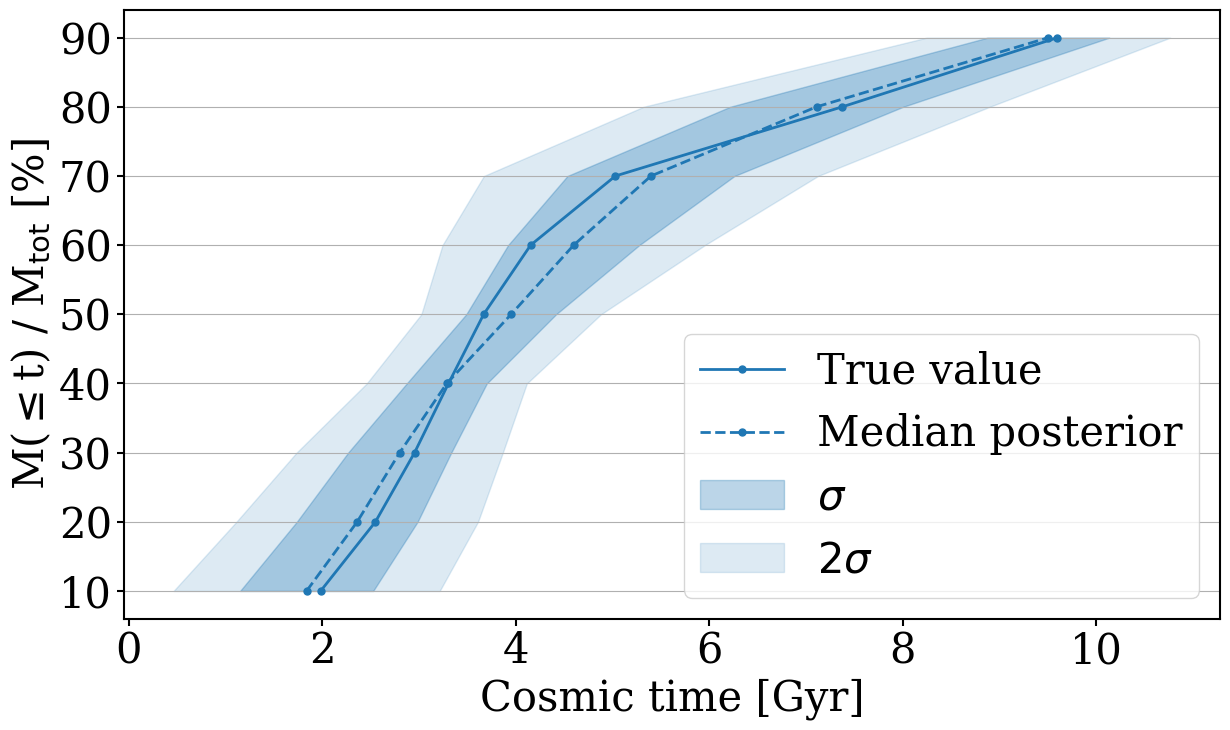

145848


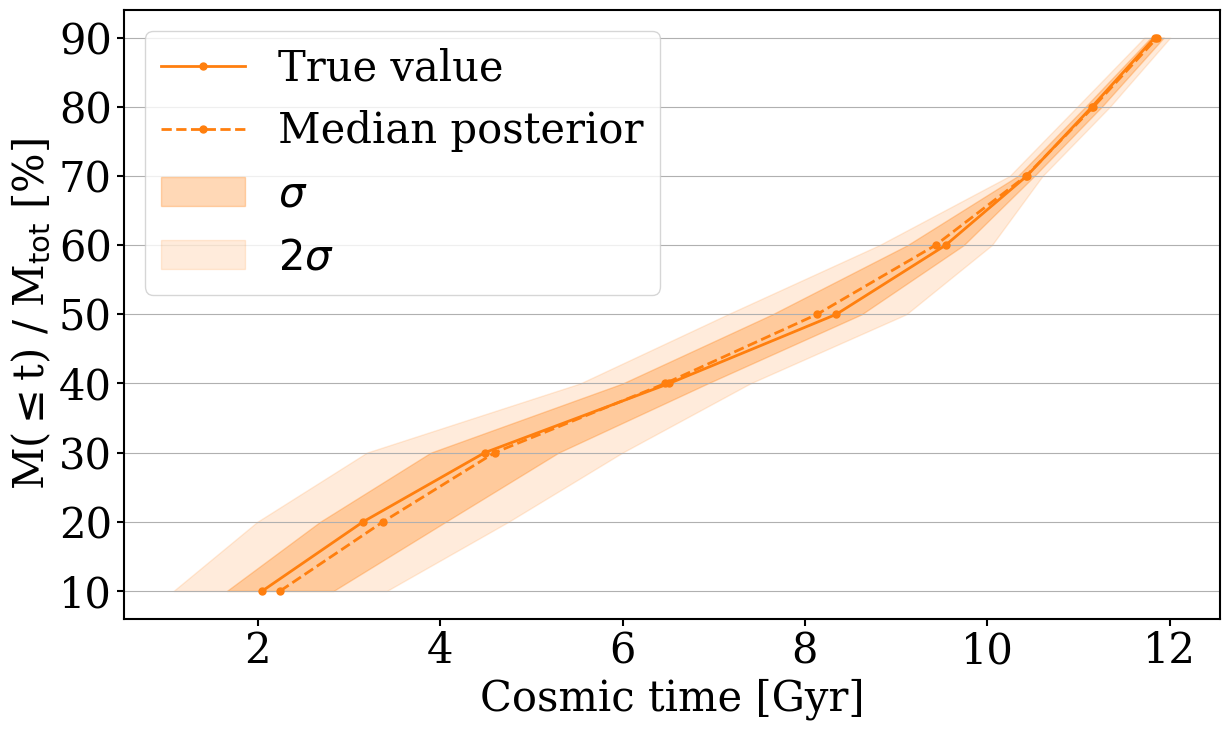

149000


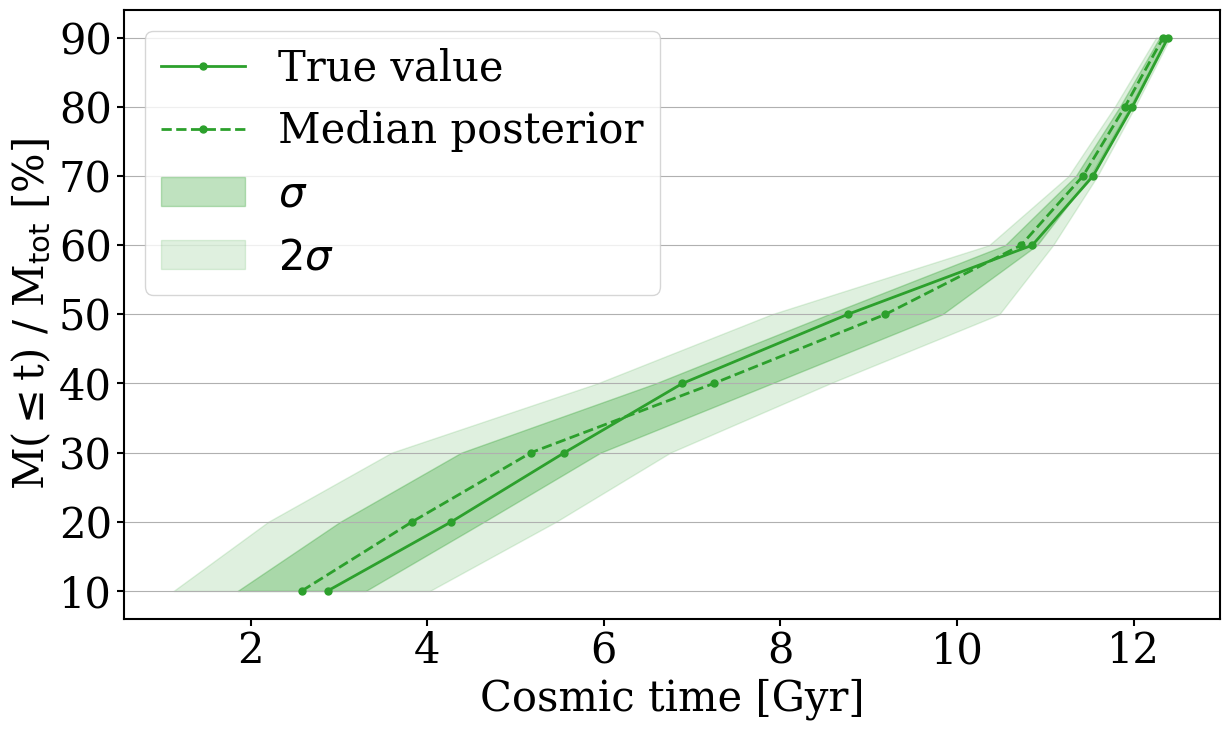

143281


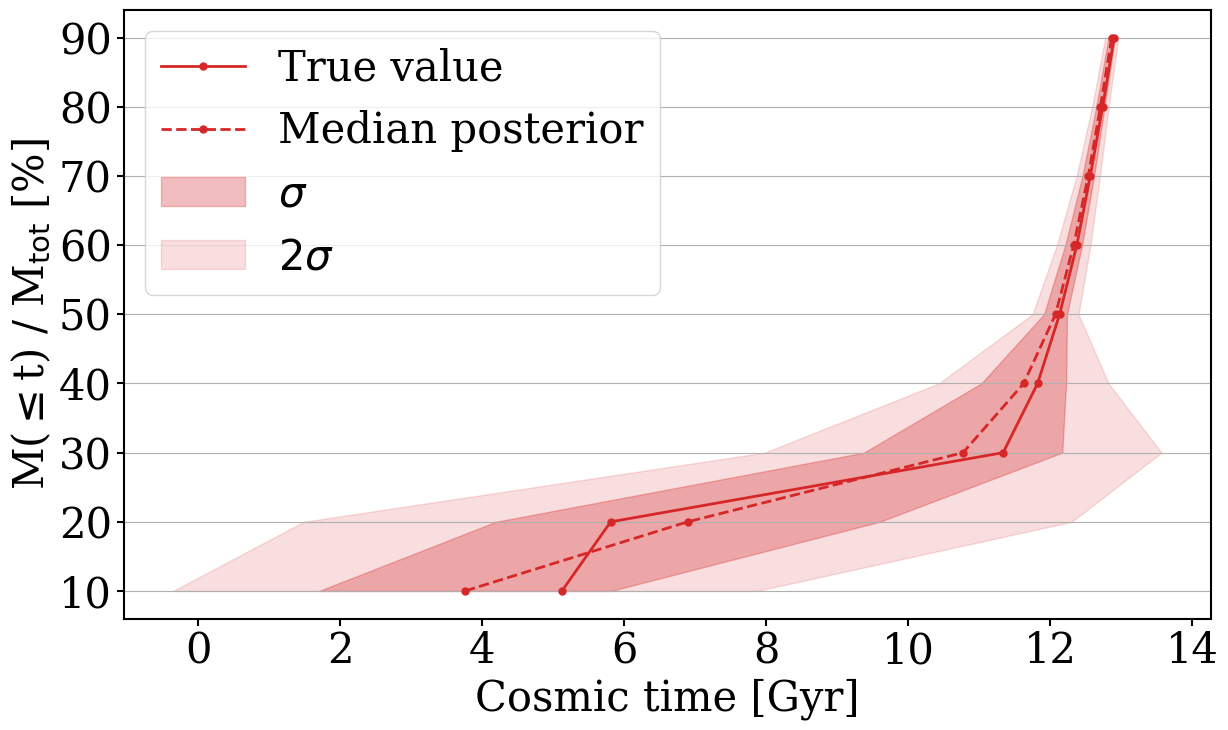

141216


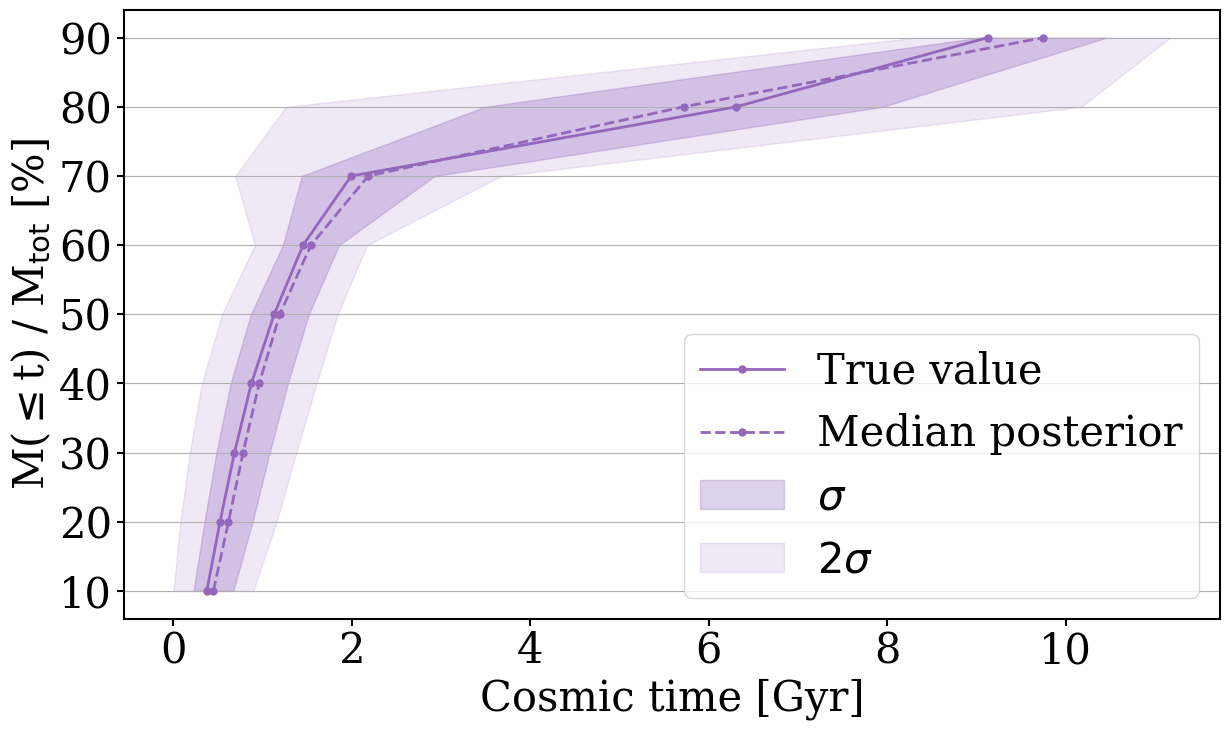

144701


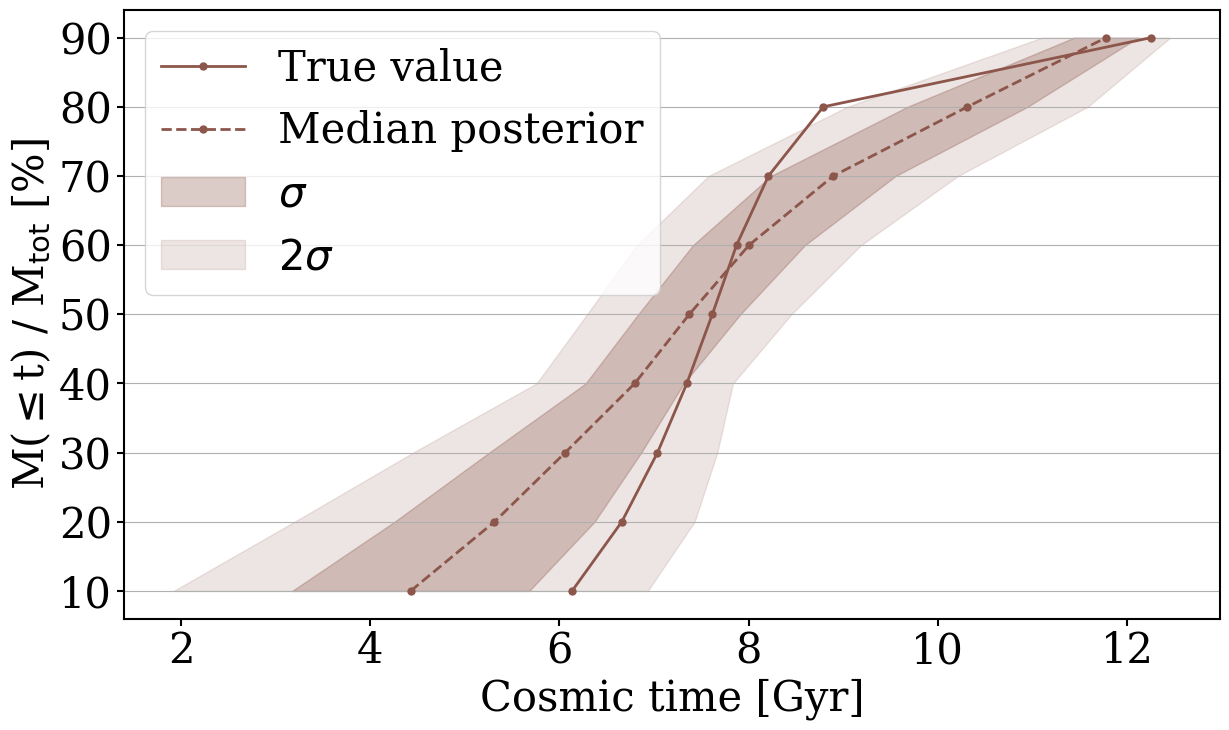

144337


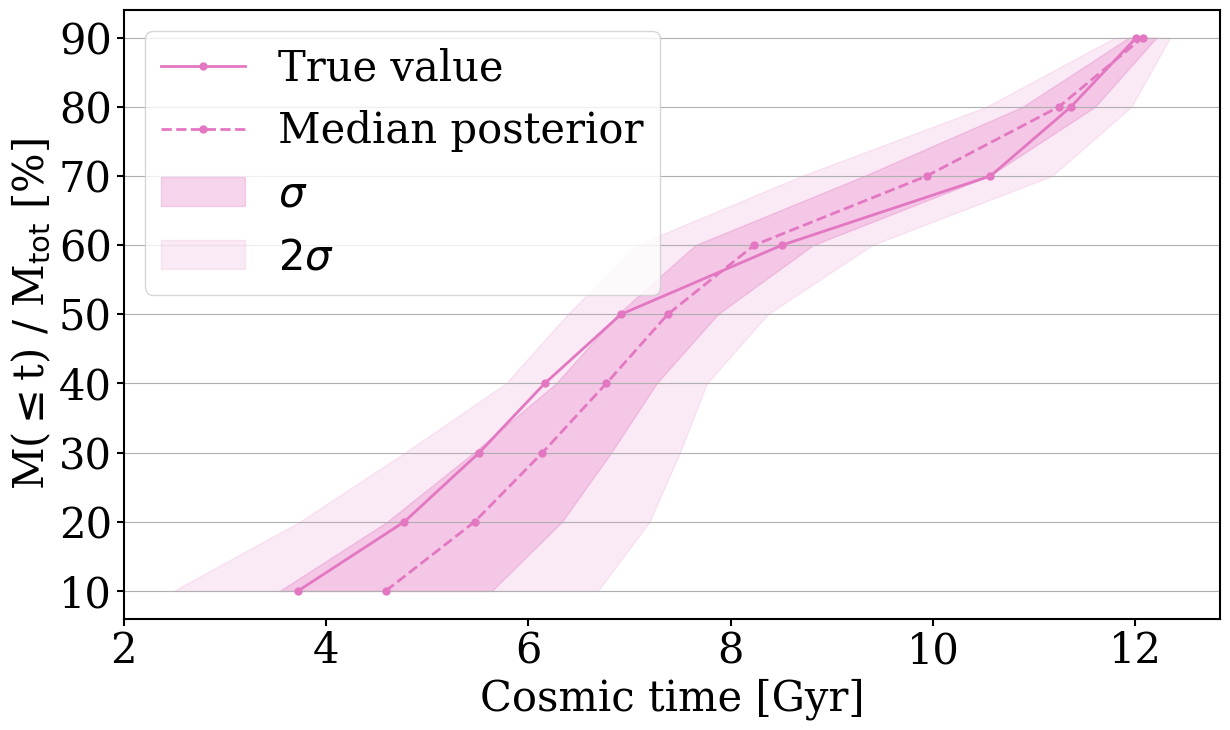

148656


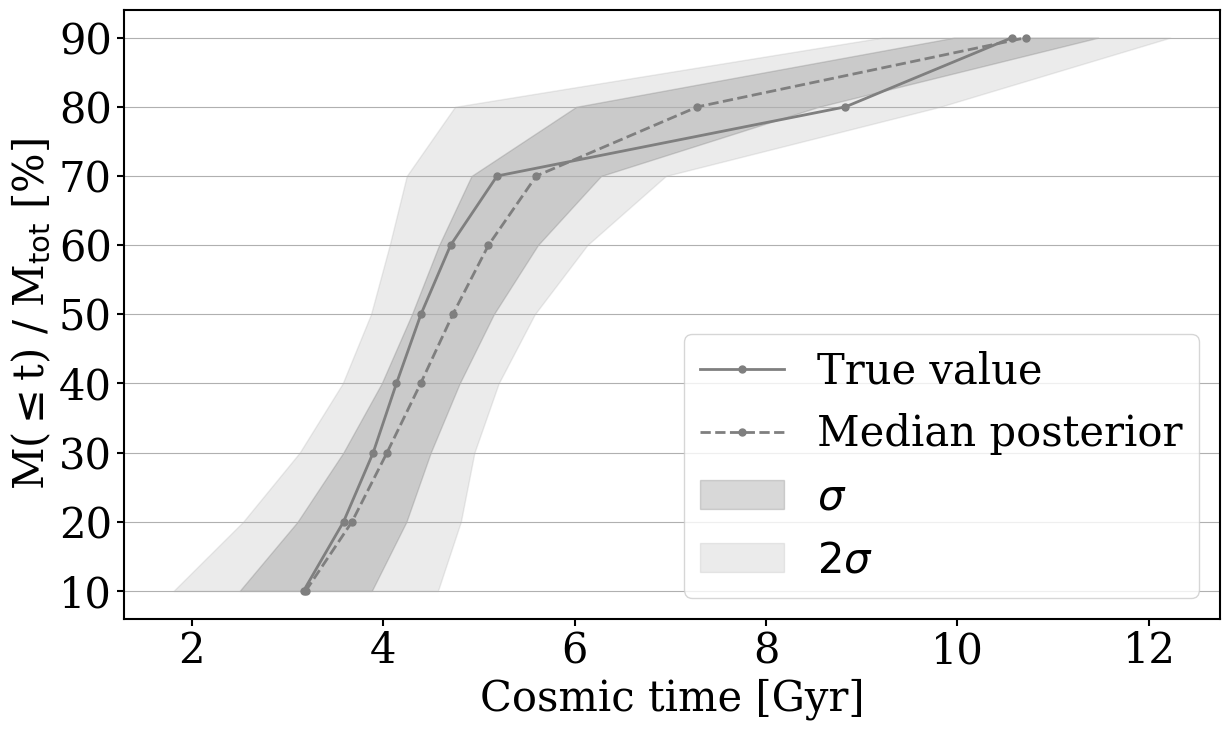

143847


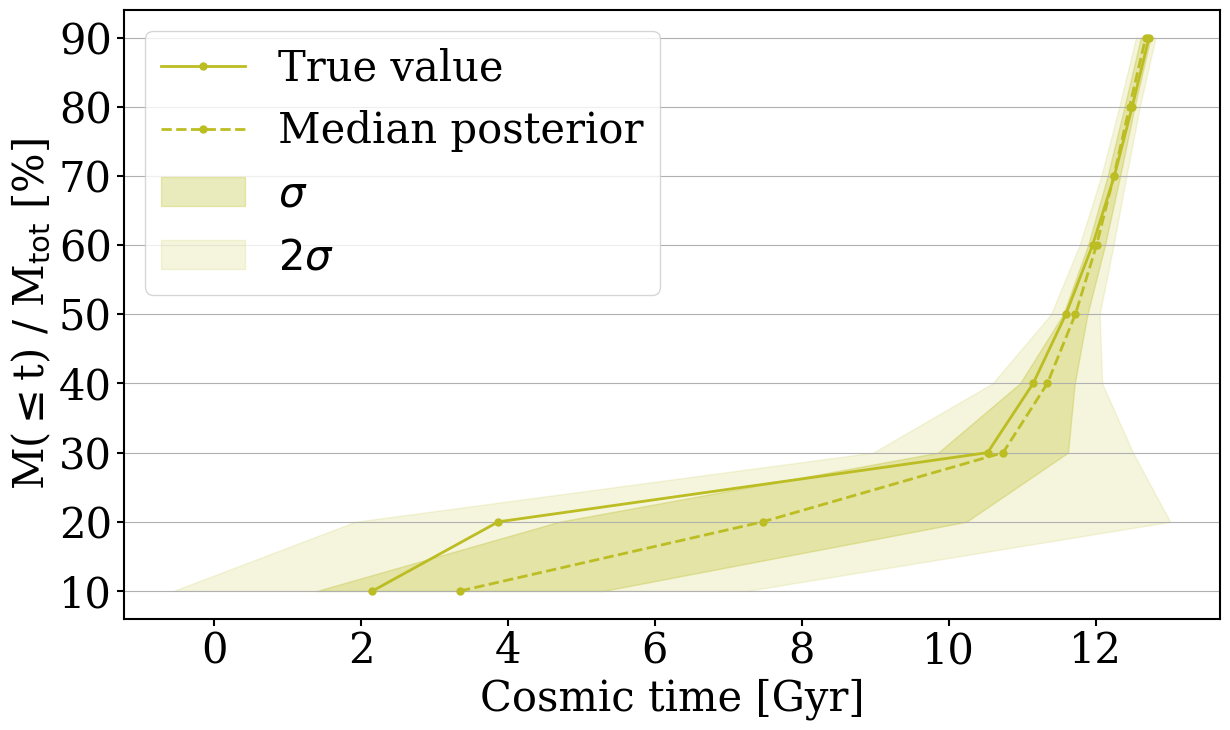

142319


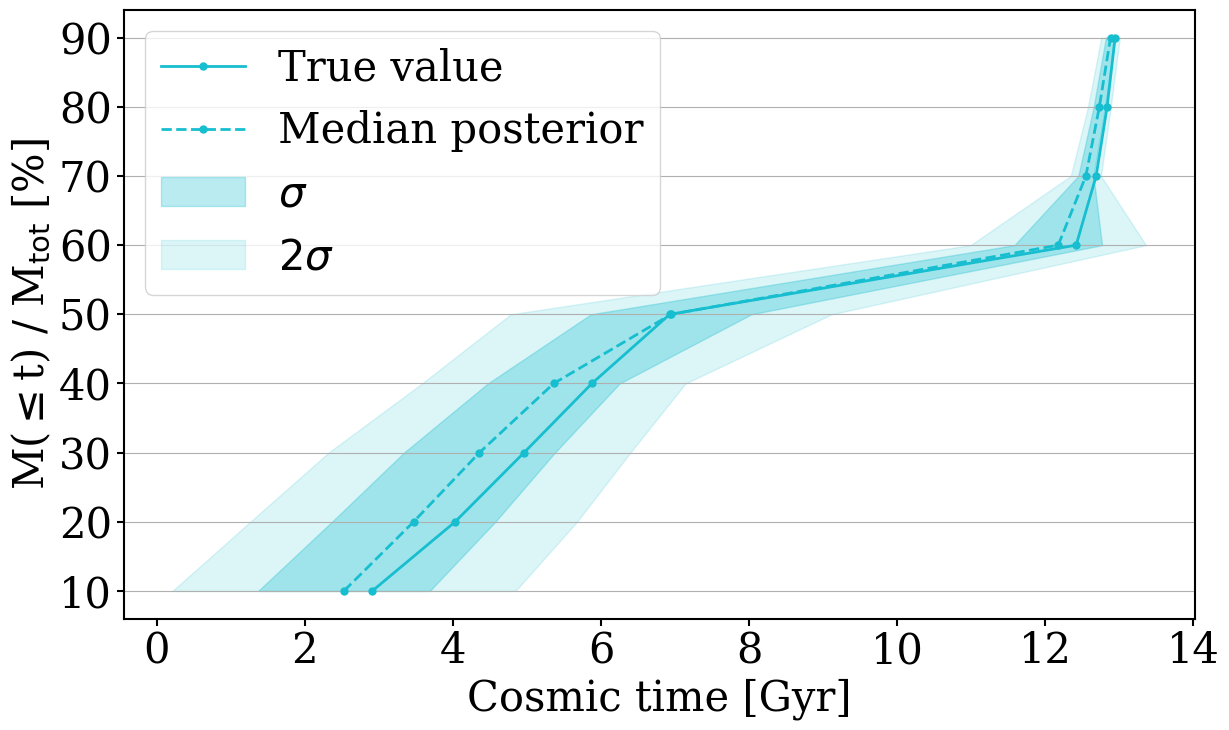

140873


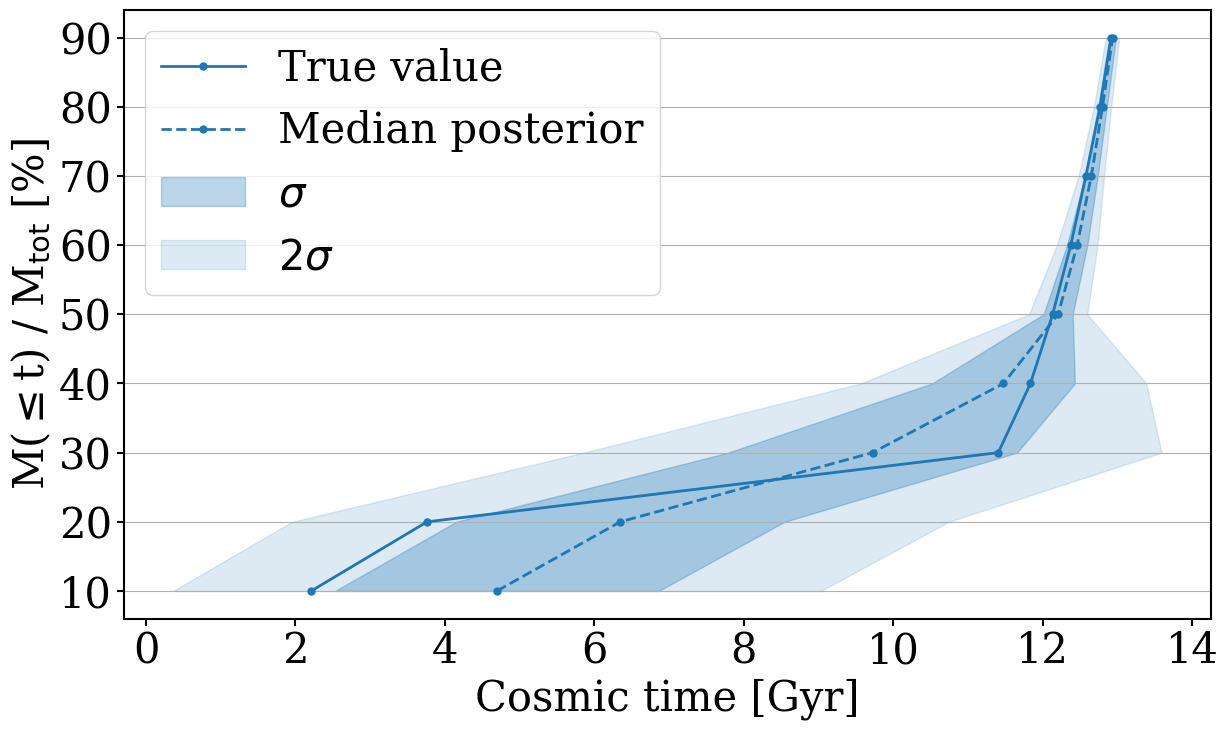

143856


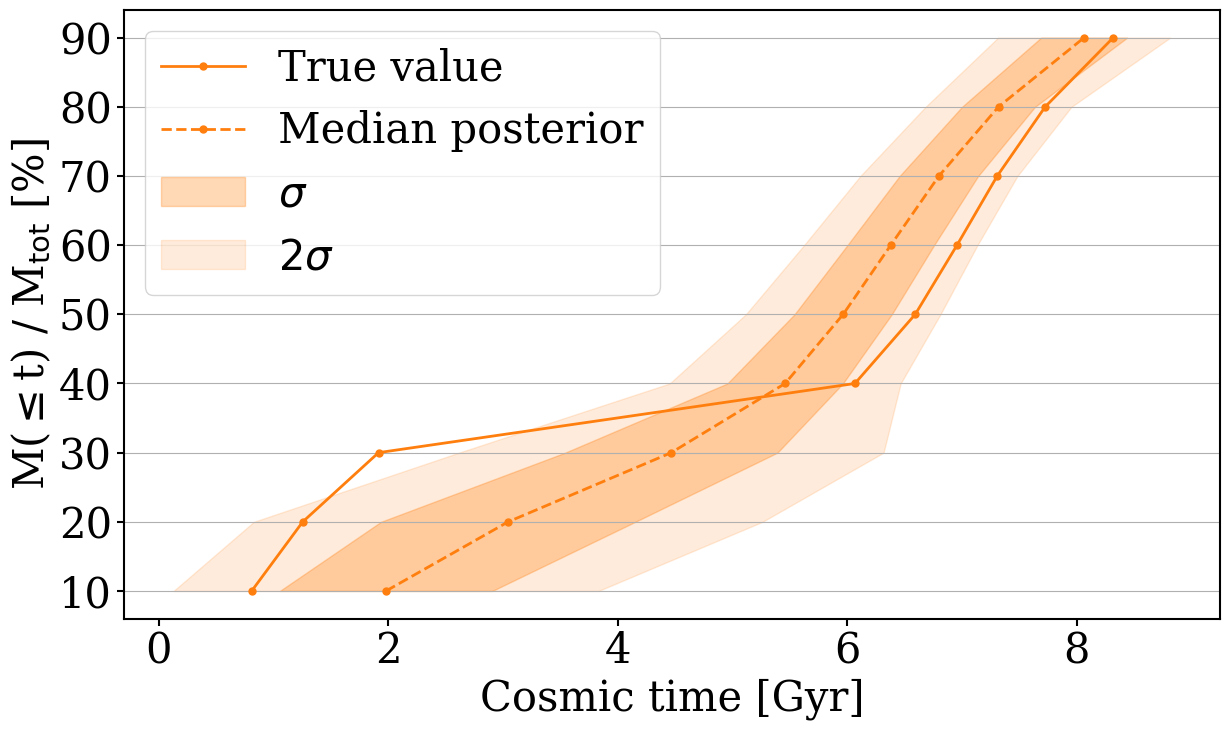

144197


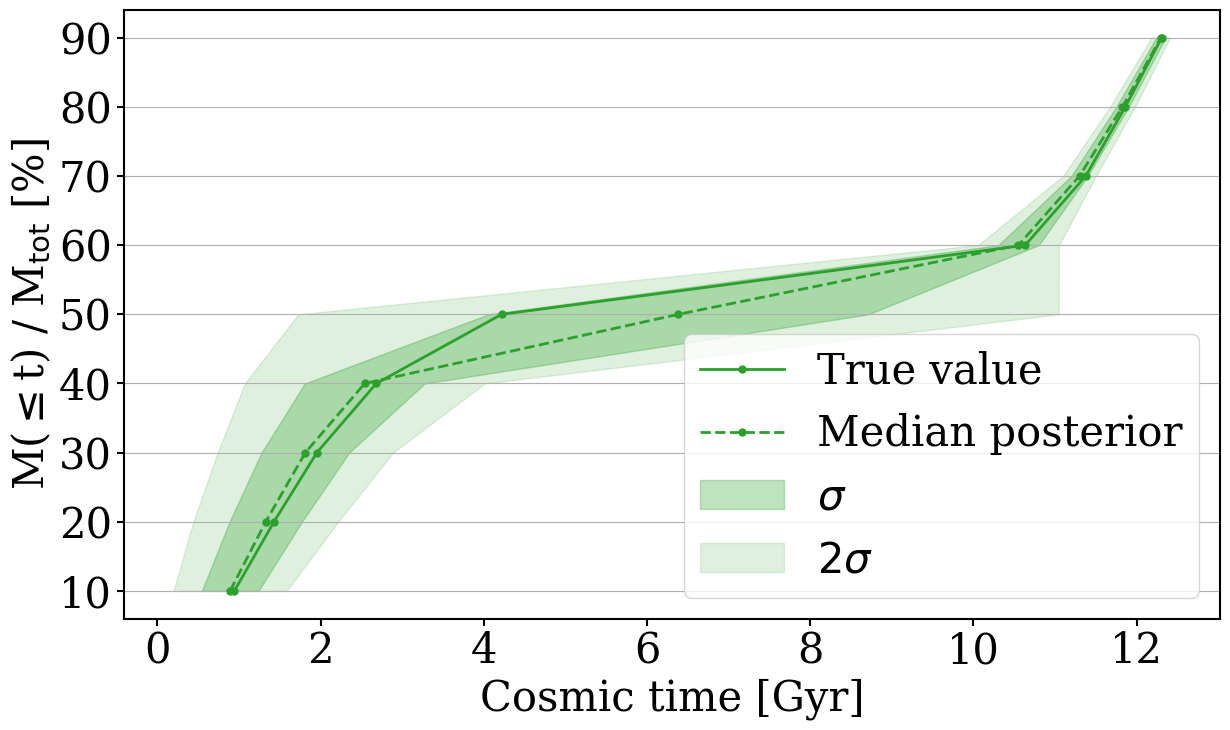

147777


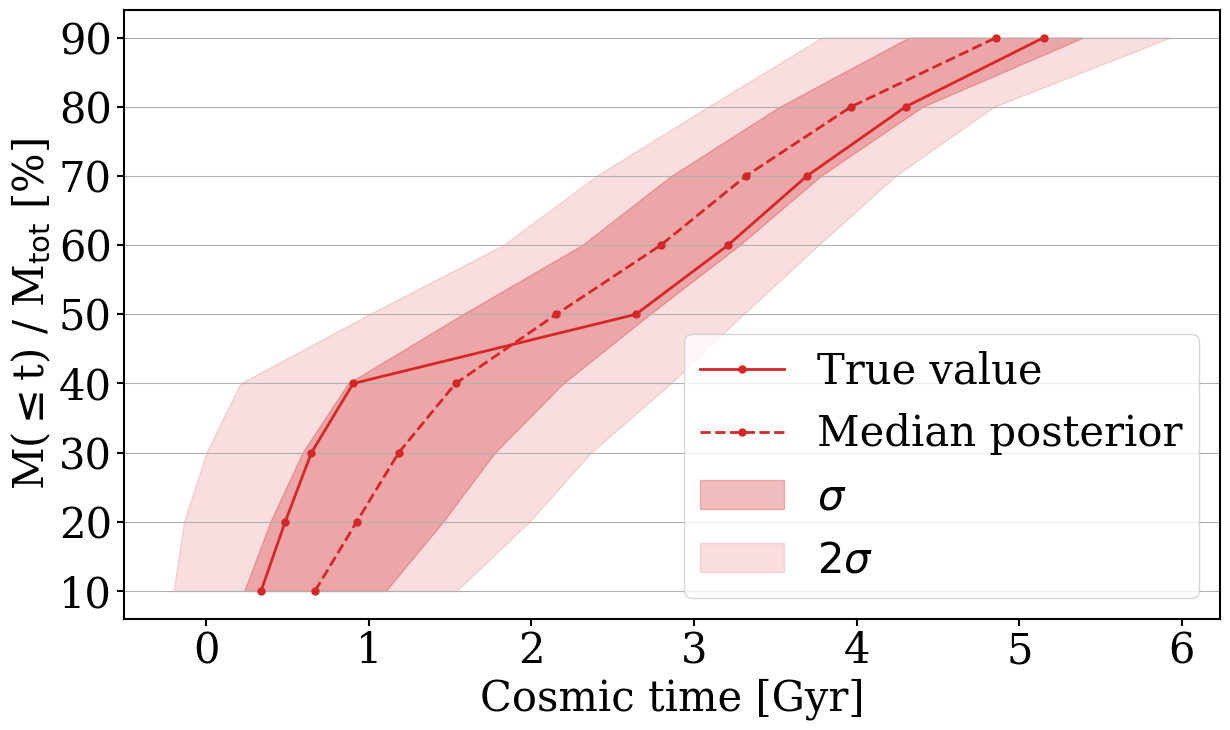

144681


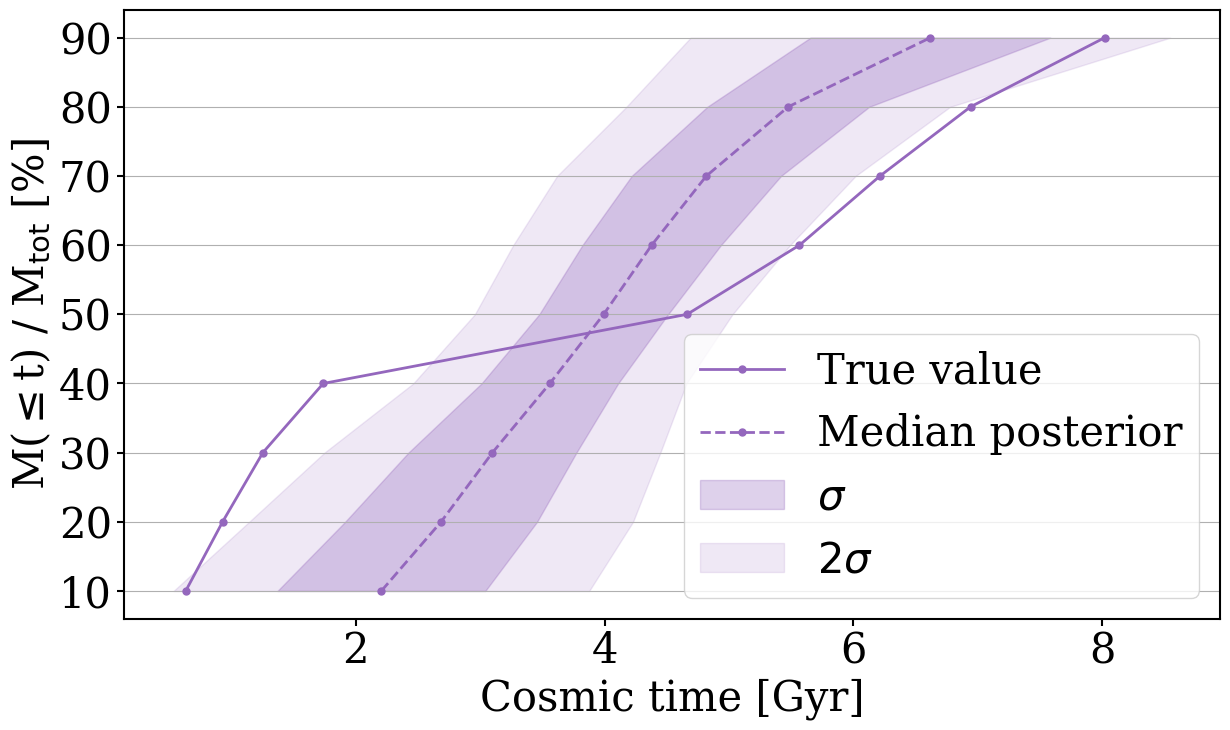

In [7]:
def plot_percentile_distribution(index_list=np.random.randint(135000,150000,15)):

    """Plot stellar mass percentiles vs cosmic time, both the real and the predicted by the model (sampling the posteriors)

        Parameters
        ----------
        index_list: array
                    Indeces from the test sample to estimate and plot the percentiles (after sampling the full dataset)
        """
    
    
    for k,j in enumerate(index_list):
            print(j)
            Xobs=latents[j,:]
            #obtain posteriors for these galaxies
            posterior_samples= np.array(qphi.sample((10000,), 
                                                x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                    show_progress_bars=False).detach().to('cpu'))
            #plot true and predicted mass-growth curve 
            plt.figure(figsize=(13,8))
            plt.plot(percentiles[j,:9],np.arange(10,100,10),'.-',color='C'+str(k),label='True value',lw=2,ms=10)
            plt.plot(np.mean(posterior_samples,axis=0)[:9],np.arange(10,100,10),'.--',color='C'+str(k),label='Median posterior',lw=2,ms=10)

            #Shadow according to the standard deviation
            plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)[:9]+np.std(posterior_samples[:,:9],axis=0),np.mean(posterior_samples,axis=0)[:9]-np.std(posterior_samples[:,:9],axis=0),color='C'+str(k),alpha=0.3,label='$\\sigma$')
            plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)[:9]+2*np.std(posterior_samples[:,:9],axis=0),np.mean(posterior_samples,axis=0)[:9]-2*np.std(posterior_samples[:,:9],axis=0),color='C'+str(k),alpha=0.15,label='$2\\sigma$')
            
            #plt.title('Percentiles')
            plt.legend()
            plt.yticks(np.arange(10,100,10))
            plt.xlabel('Cosmic time [Gyr]')
            plt.ylabel('M($\leq$t) / M$_{\\rm tot}$ [%]')
            plt.tight_layout()
            plt.grid(axis='y')
            #plt.savefig('prediction_'+str(k)+'.pdf')
            plt.show()

        
plot_percentile_distribution()

Show metallicity distributions predicted for galaxies from the test sample with indeces in 'index_list'

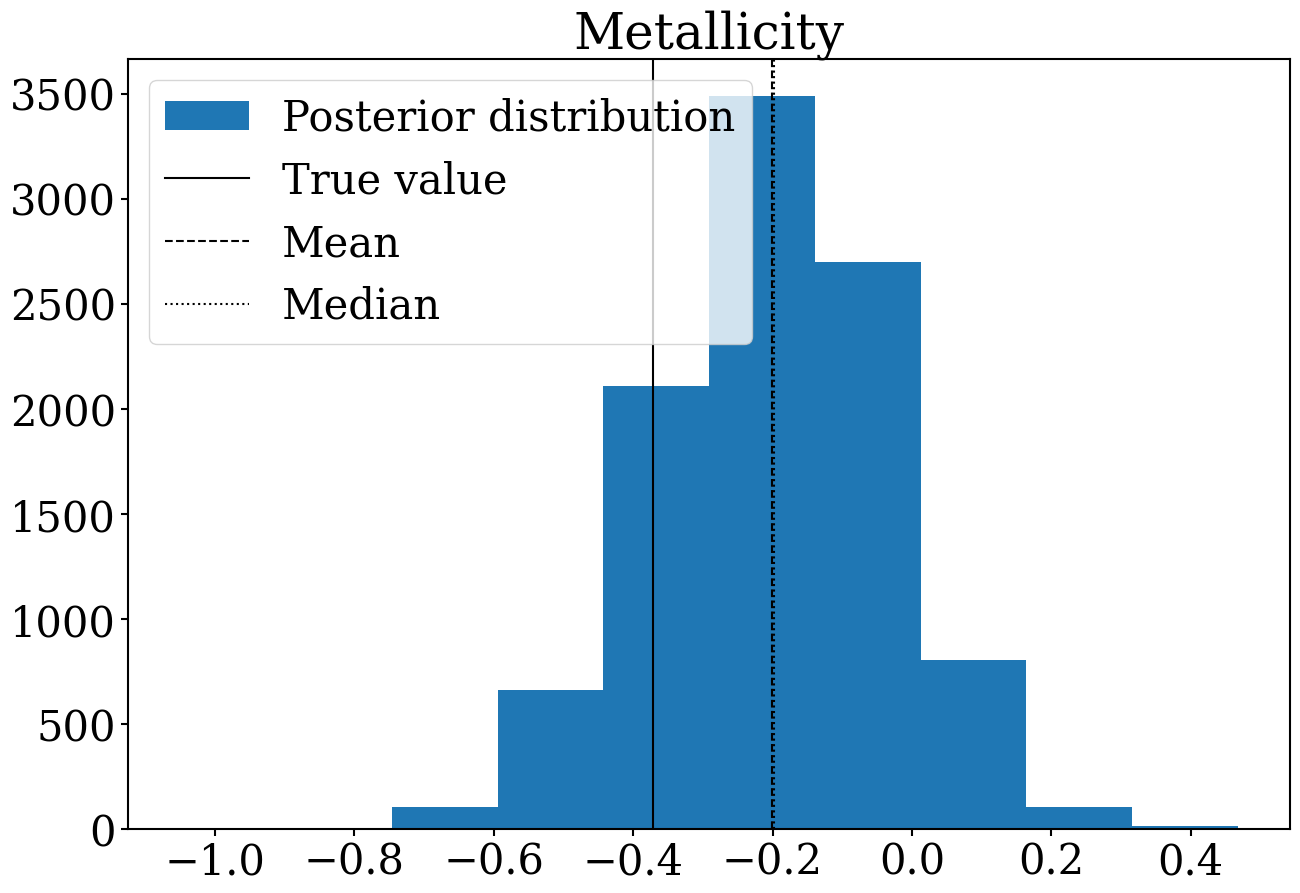

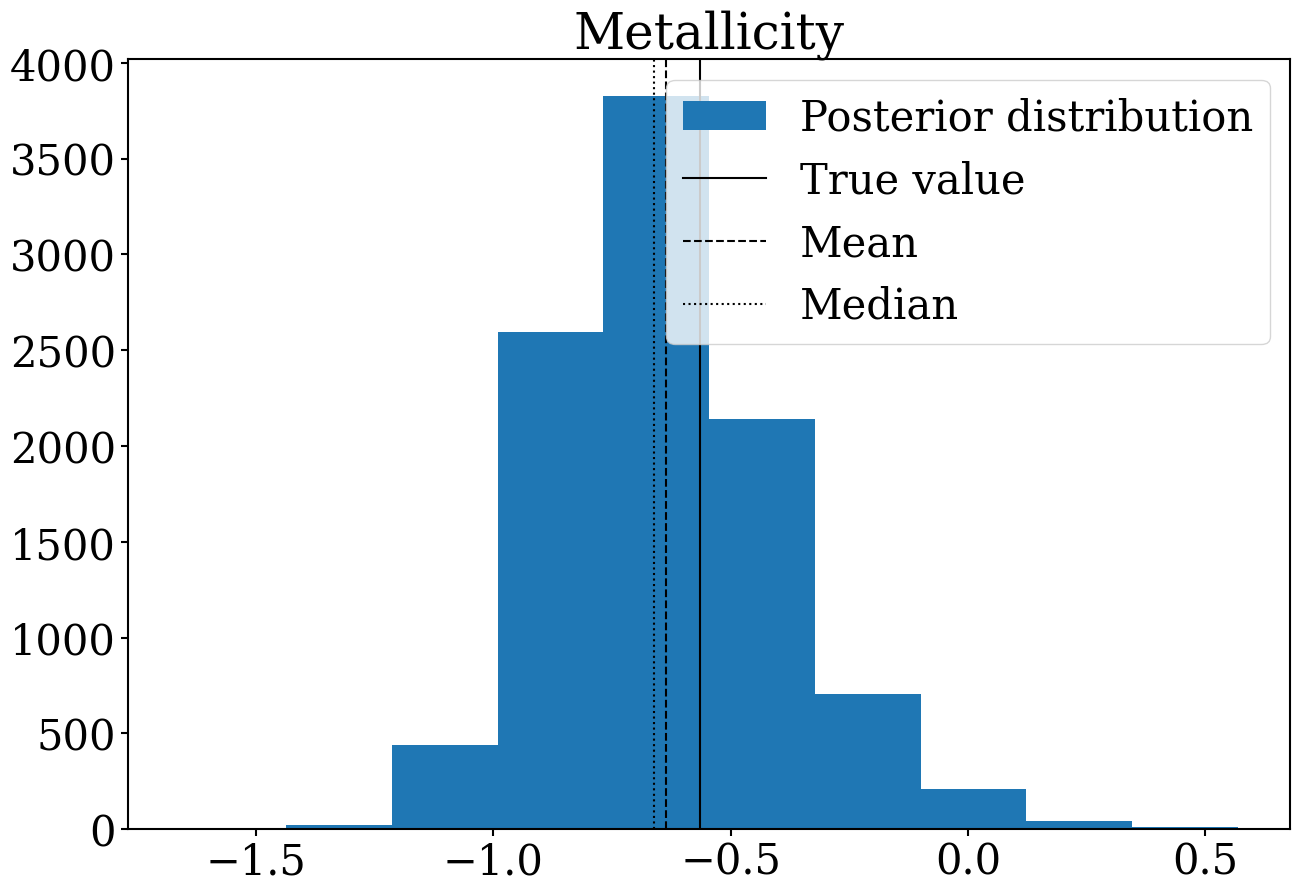

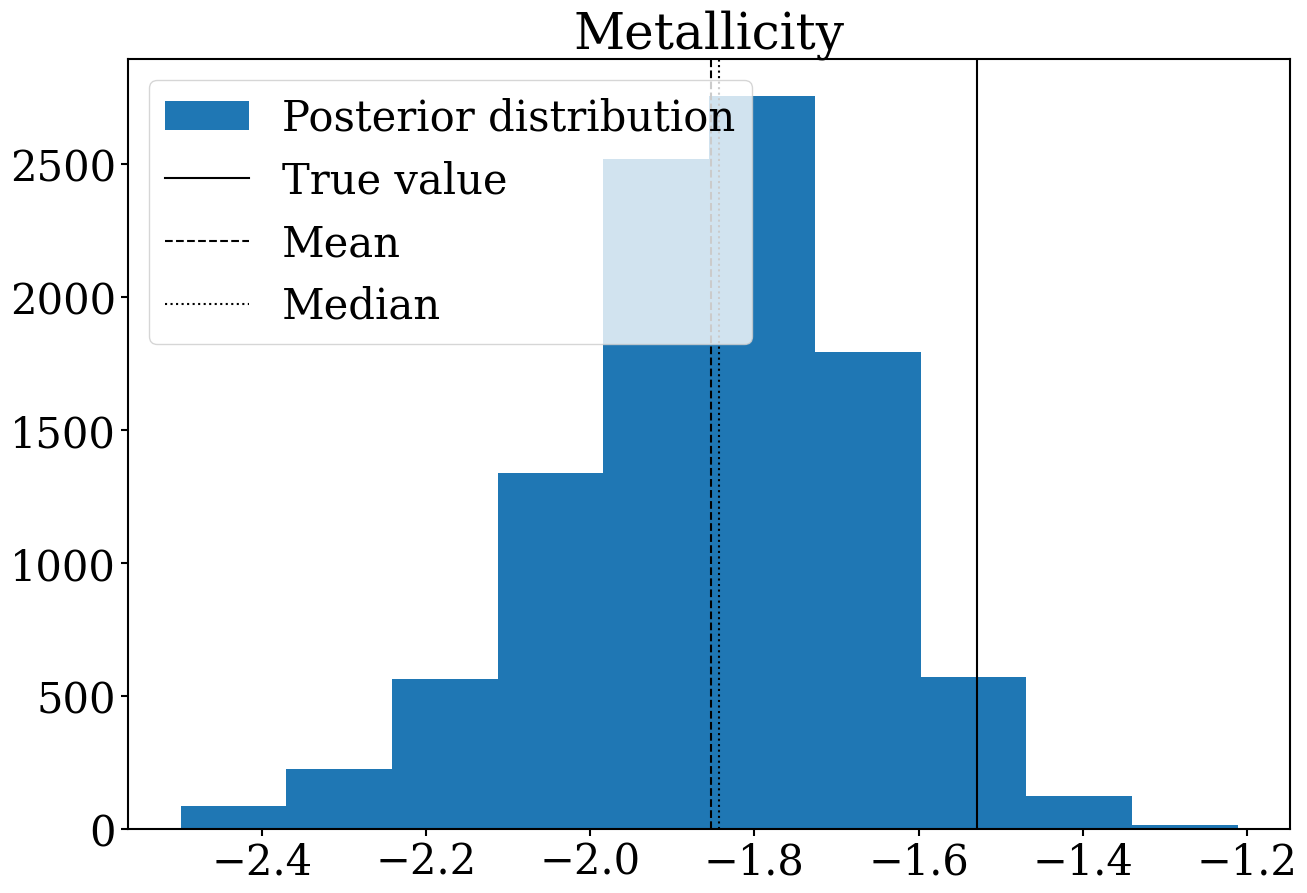

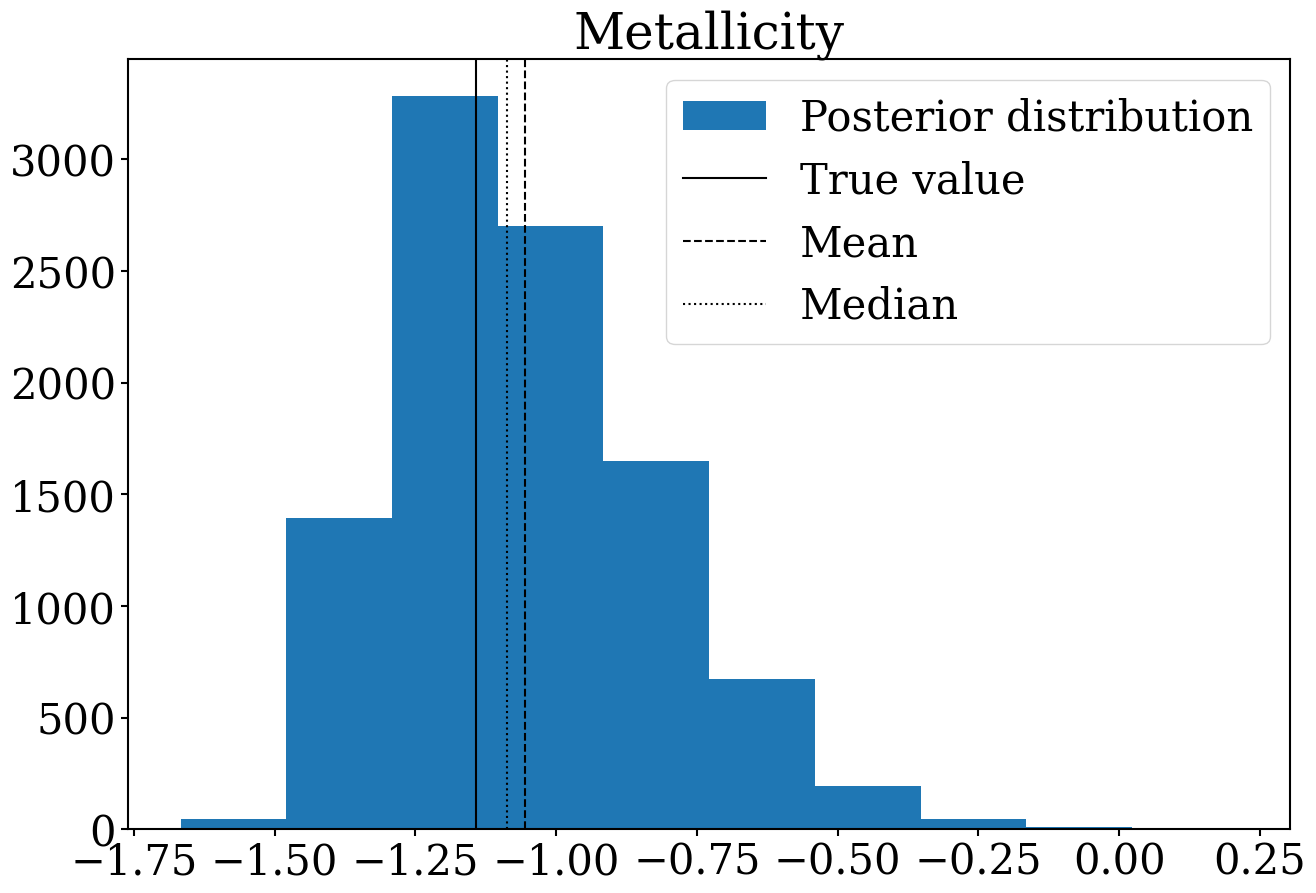

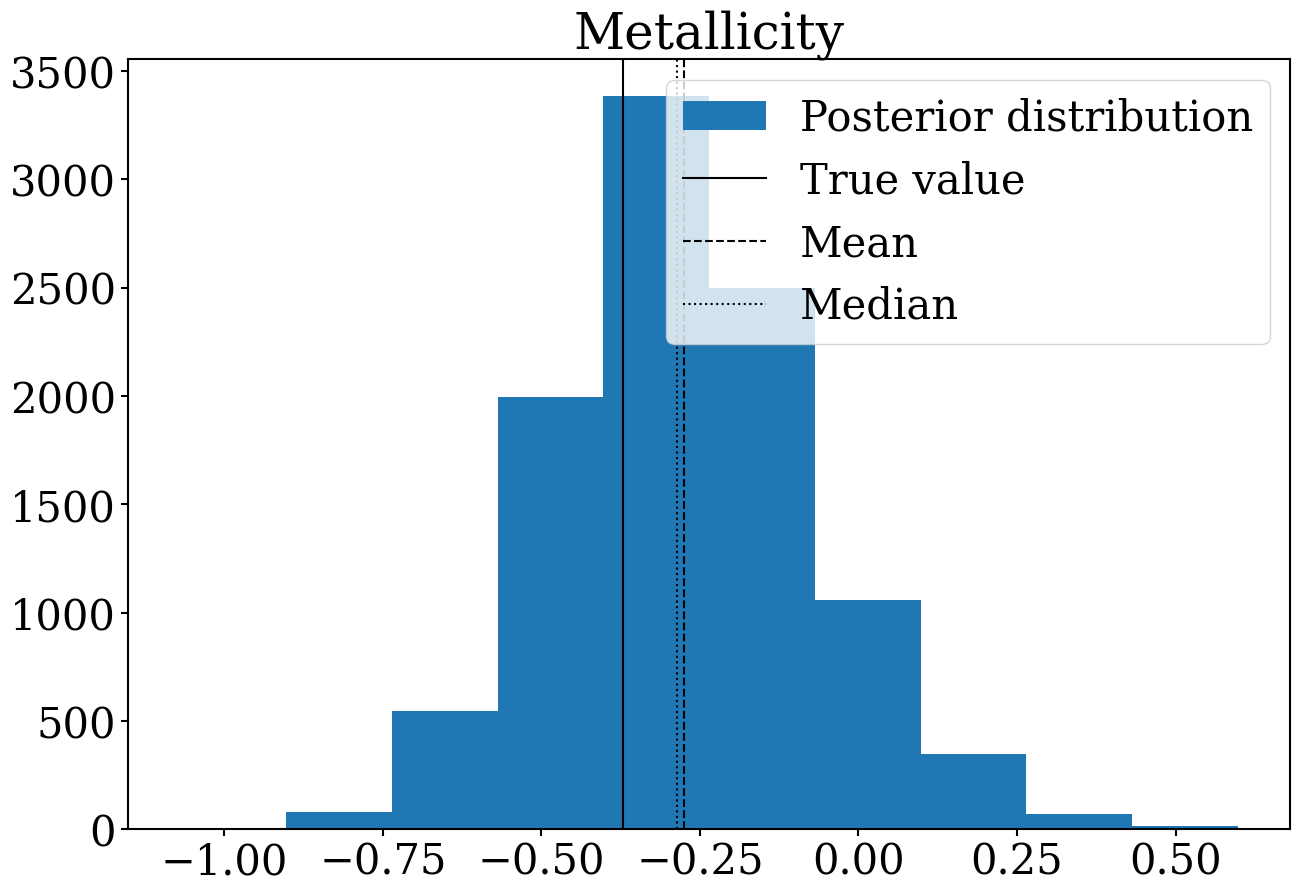

In [ ]:
index_list=np.random.randint(135000,150000,5)

for k,j in enumerate(index_list):
                Xobs=latents[j,:]
                posterior_samples= np.array(qphi.sample((10000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))

                plt.hist(posterior_samples[:,-1],label='Posterior distribution')
                plt.axvline(percentiles[j,-1],ls='-',c='k',label='True value')
                plt.axvline(np.mean(posterior_samples[:,-1]),ls='--',c='k',label='Mean')
                plt.axvline(np.median(posterior_samples[:,-1]),ls=':',c='k',label='Median')
                plt.title('Metallicity')
                plt.legend()
                plt.show()

               

Compute the median of the posterior distributions predicted for the test sample (for each feature)

In [10]:
n_evaluations=15000 #size of the test sample
n_samples=1000 #number of evaluations of the posterior
index_list=np.arange(135000,150000) #list indeces of test sample in the previously shuffled full dataset

stds=[]
means=[]

for k,j in tqdm(enumerate(index_list)): #one galaxy at a time
    Xobs=latents[j,:]
    posterior_samples= np.array(qphi.sample((n_samples,), x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), show_progress_bars=False).detach().to('cpu'))  #sample the posteriors for each galaxy
    stds.append(np.std(posterior_samples,axis=0))   #save in the list an array with std of each feature
    means.append(np.median(posterior_samples,axis=0)) #save in the list an array with median of each feature
    
#Save medians and standard deviations for the test set and the 10 features predicted
np.save('./saved_models/means.npy',means)
np.save('./saved_models/stds.npy',stds)

15000it [1:17:19,  3.23it/s]


Using the medians and comparing them with the true values for the features to estimate, compute accuracies for each feature in the test sample.

In [11]:
#COMPUTE ACCURACY

index_list=np.arange(135000,150000)
means=np.load('./saved_models/means.npy')
stds=np.load('./saved_models/stds.npy')

accuracy=[]
for i in range(10):
    if i<9:
        p0=np.where(percentiles[index_list,i]>1e-1)[0]
        accuracy.append(100-np.mean(np.abs(means[:,i][p0]-percentiles[index_list,i][p0])/np.abs(percentiles[index_list,i][p0]) * 100))
    else:
        accuracy.append(100-np.mean(np.abs(means[:,i]-percentiles[index_list,i])/np.abs(percentiles[index_list,i]) * 100))

print(np.around(accuracy,decimals=2))

[62.39 70.9  78.9  84.64 88.23 91.55 93.98 96.1  97.98  3.98]


Plot medians of the posterior distributions estimated for the percentiles and [M/H], compared to the true values. The accuracy achieved for each prediction is shown. Each blue dot is a different sample from the test set. The red line shows the one-to-one relation, the histograms at the right of each panel show the marginal distributions of the predictions, and the histograms of the real data are shown at the top. Kernel Density Estimation (KDE) contours are drawn in black at iso-proportions of the density of samples.

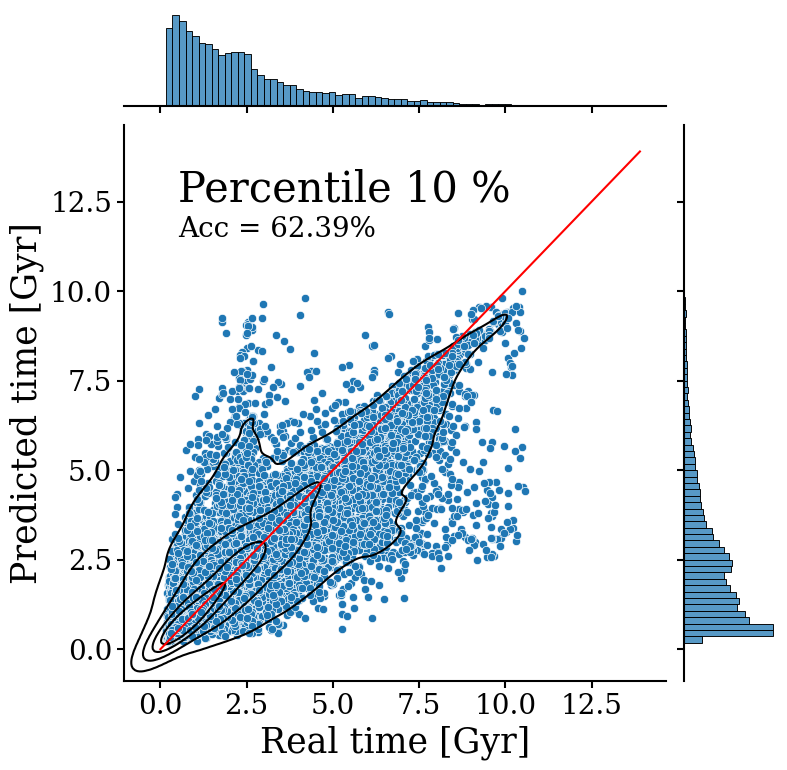

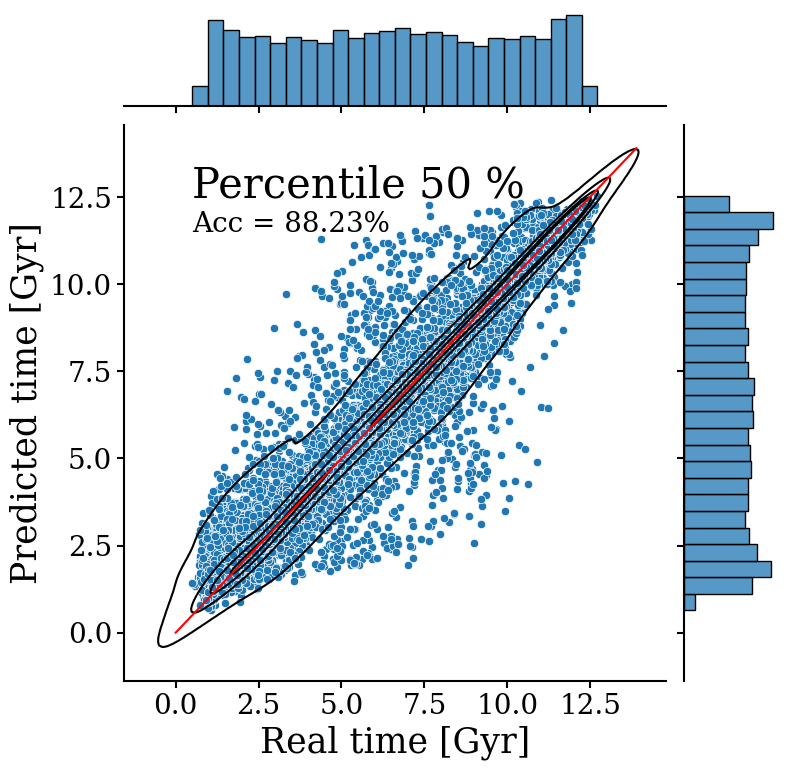

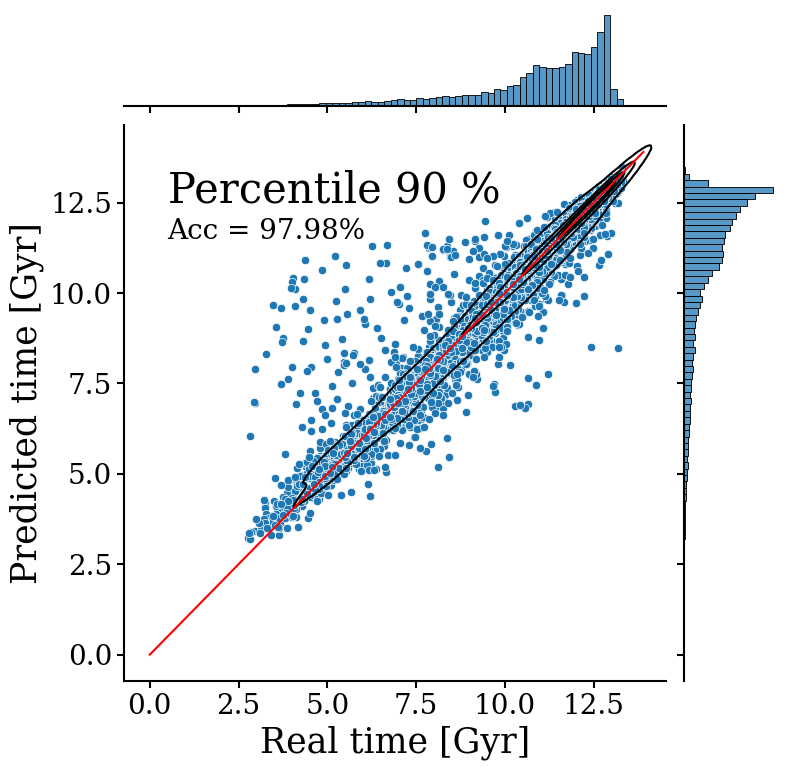

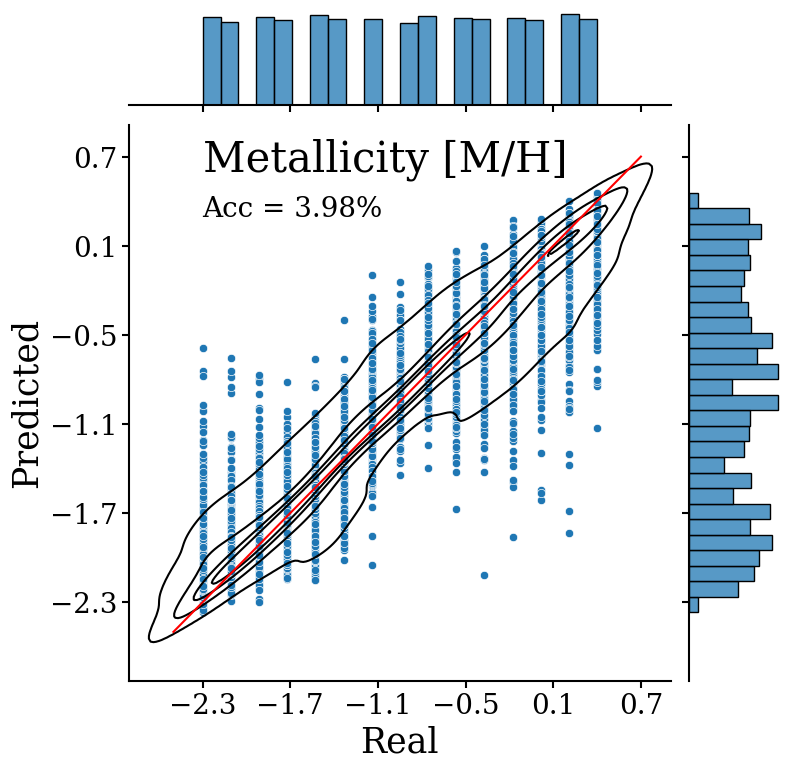

In [14]:
index_list=np.arange(135000,150000)
means=np.load('./saved_models/means_sfr.npy') #change if needed
stds=np.load('./saved_models/stds_sfr.npy')

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20


import seaborn as sns

for i in [0,4,8,9]:
    
    p=percentiles[index_list,i]

    if i<9:
        g=sns.jointplot(x=p, y=means[:,i],height=8,label='Test data',legend=False)#kind='reg')
        x=np.arange(0,14,0.1)
        kde=g.plot_joint(sns.kdeplot, color="k", zorder=1, levels=5,label='KDE')
        d=g.ax_joint.plot(x, x, '-r',label='y=x')

        g.set_axis_labels('Real time [Gyr]','Predicted time [Gyr]',fontsize=25)
        g.ax_joint.set_xticks(np.arange(0,15,2.5))
        g.ax_joint.set_yticks(np.arange(0,15,2.5))
        g.ax_joint.text(0.5,12.5,'Percentile '+str((i+1)*10)+' %',fontsize=30)
        g.ax_joint.text(0.5,11.5,'Acc = '+str(np.around(accuracy[i],2))+'%',fontsize=20)
        
    
    elif i==9:
        g=sns.jointplot(x=p, y=means[:,i],height=8,label='Test',legend=False)#,kind='kde')
        kde=g.plot_joint(sns.kdeplot, color="k", zorder=1, levels=5, label='KDE')
        x=np.arange(-2.5,0.8,0.1)
        d=g.ax_joint.plot(x, x, '-r',label='y=x')
        g.set_axis_labels('Real',
        'Predicted',fontsize=25)
        g.ax_joint.set_xticks([-2.3,-1.7,-1.1,-0.5,0.1,0.7])
        g.ax_joint.set_yticks([-2.3,-1.7,-1.1,-0.5,0.1,0.7])
        g.ax_joint.text(-2.3,0.6,'Metallicity [M/H]',fontsize=30)
        g.ax_joint.text(-2.3,0.3, 'Acc = '+str(np.around(accuracy[i],2))+'%',fontsize=20)
    #g.savefig('sns_mean_true_kde_6_'+str(i)+'.jpg')
    plt.show()